<a href="https://colab.research.google.com/github/rajy4683/EIP4_Phase1_Final/blob/master/WRN_A5_wide_rkg_wrn_gml_rkg_rjy_gml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [2]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Conv2D, BatchNormalization, Activation



Using TensorFlow backend.


In [3]:
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm

import tensorflow.contrib.eager as tfe
#tf.enable_eager_execution()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [5]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [6]:
one_hot_df.head()


,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/1.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,resized/2.jpg,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
2,resized/3.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,resized/4.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,resized/5.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0


In [0]:
import keras
import numpy as np
from google.colab.patches import cv2_imshow
from tensorflow.python.keras.utils.data_utils import Sequence

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

#class PersonDataGenerator(keras.utils.Sequence):
class PersonDataGenerator(Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True,normalize=False,aug_flow=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.normalize = normalize
        self.on_epoch_end()
        self.aug_flow=aug_flow
        #print("Shuffle = ",self.shuffle)

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        #print(batch_slice)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        #print(items["image_path"])
        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        if(self.aug_flow is not None):
            image = self.aug_flow.flow(image,shuffle=False,batch_size=self.batch_size).next()
        if(self.normalize == True):
            train_mean = np.mean(image, axis=(0,1,2))
            train_std = np.std(image, axis=(0,1,2))
            #print(train_mean, train_std)
            normalize = lambda x: ((x - train_mean) / train_std).astype('float32')
            image = normalize(image)


        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [8]:
train_old_df =pd.read_csv('/content/gdrive/My Drive/WRN_Extend/train_df_wrn2_widrn_acc_1577202722.csv') 
train_df = train_old_df
val_old_df = pd.read_csv('/content/gdrive/My Drive/WRN_Extend/val_df_wrn2_widrn_acc_1577202722.csv')
val_df=val_old_df
print(train_df.shape, val_df.shape)

(11537, 28) (2036, 28)


In [9]:
train_df

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/7499.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0
1,resized/9410.jpg,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
2,resized/2396.jpg,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0
3,resized/9839.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1
4,resized/80.jpg,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,resized/2692.jpg,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0
11533,resized/2657.jpg,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
11534,resized/1842.jpg,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
11535,resized/7815.jpg,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1


In [10]:
from datetime import datetime
def get_curr_time():
    return int(datetime.utcnow().strftime("%s"))

model_name_itr = 'wrn2_rkg_fresh_wrn_wide_rjy2_gml2_'+str(get_curr_time())
gdrive_home_path="/content/gdrive/My Drive/WRN_Extend/"
train_csv=gdrive_home_path+"train_df_"+model_name_itr+".csv"
val_csv=gdrive_home_path+"val_df_"+model_name_itr+".csv"
json_file=gdrive_home_path+"json_"+model_name_itr+".json"
png_file=gdrive_home_path+"png_"+model_name_itr+".png"
weights_file=gdrive_home_path+"h5_"+model_name_itr+".h5"

print("Model-name:",model_name_itr)
print(train_csv,val_csv,json_file,png_file,weights_file)
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)

# /content/gdrive/My Drive/train_df_wrn2_widrn_acc_1577202722.csv 
# /content/gdrive/My Drive/val_df_wrn2_widrn_acc_1577202722.csv 
# /content/gdrive/My Drive/json_wrn2_widrn_acc_1577202722.json
#  /content/gdrive/My Drive/png_wrn2_widrn_acc_1577202722.png 
#  /content/gdrive/My Drive/h5_wrn2_widrn_acc_1577202722.h5

Model-name: wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977
/content/gdrive/My Drive/WRN_Extend/train_df_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.csv /content/gdrive/My Drive/WRN_Extend/val_df_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.csv /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.json /content/gdrive/My Drive/WRN_Extend/png_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.png /content/gdrive/My Drive/WRN_Extend/h5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.h5


In [11]:
print("Model-name:",model_name_itr)
for var_name in [train_csv,val_csv,json_file,png_file,weights_file]:
  print(var_name)

Model-name: wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977
/content/gdrive/My Drive/WRN_Extend/train_df_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.csv
/content/gdrive/My Drive/WRN_Extend/val_df_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.csv
/content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.json
/content/gdrive/My Drive/WRN_Extend/png_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.png
/content/gdrive/My Drive/WRN_Extend/h5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.h5


In [0]:
output_weights = ["gender_output", "imagequality_ouput","age_output", "weight_output", "bag_output", "footwear_output","emotion_output", "pose_output"]
col_splits = [_gender_cols_, _imagequality_cols_,_age_cols_, _weight_cols_, _carryingbag_cols_, _footwear_cols_, _emotion_cols_, _bodypose_cols_]
def get_dist(train_df,equalize_classes=False):
    loss_weights = {}
    index=0
    for selector_column in col_splits:
        print(selector_column)
        count = []
        percentile = []
        for age_split in selector_column:
            count.append( train_df[selector_column][train_df[age_split] == 1].shape[0])
        #print(count, np.round((count/11537.0)*100.0, 2))

        max_val = np.max(count)
        total_count = np.float32(train_df.shape[0])
        #print(count, )
        count_weights= [np.round(max_val/current_val,3) for current_val in count]
        print(count_weights)
        print(np.round((np.asarray(count)/total_count)*100.0, 2))

        #print("Top Class:",selector_column[np.argmax(count)],"Max Count",np.max(count))
        #print("Bottom Class:",selector_column[np.argmin(count)])
        #weights_dist = dict(zip(selector_column, count_weights))
        
        #print(weights_dist)
        weights_vals_dist={}
        index_val=0
        for y in range(len(count_weights)):
            weights_vals_dist[y]=count_weights[y]
            print(weights_vals_dist[y],y)
            #index_val+=index_val
            
            #loss_weights[output_weights[index]]={x,y}
        loss_weights[output_weights[index]]=weights_vals_dist
        #if equalize_classes == True:
        #    expanded_df = equalize_classwise_dist(train_df, selector_column, count)
        #    train_df = train_df.append(expanded_df, ignore_index=True)
        index+=1
    #print(loss_weights)
    return train_df,loss_weights

In [13]:
_,loss_weights_train=get_dist(train_df, equalize_classes=False)
loss_weights_train

['gender_female', 'gender_male']
[1.304, 1.0]
[43.41 56.59]
1.304 0
1.0 1
['imagequality_Average', 'imagequality_Bad', 'imagequality_Good']
[1.0, 3.361, 1.979]
[55.47 16.5  28.03]
1.0 0
3.361 1
1.979 2
['age_15-25', 'age_25-35', 'age_35-45', 'age_45-55', 'age_55+']
[2.172, 1.0, 1.589, 3.556, 7.326]
[18.36 39.88 25.1  11.22  5.44]
2.172 0
1.0 1
1.589 2
3.556 3
7.326 4
['weight_normal-healthy', 'weight_over-weight', 'weight_slightly-overweight', 'weight_underweight']
[1.0, 9.632, 2.753, 9.931]
[63.79  6.62 23.17  6.42]
1.0 0
9.632 1
2.753 2
9.931 3
['carryingbag_Daily/Office/Work Bag', 'carryingbag_Grocery/Home/Plastic Bag', 'carryingbag_None']
[1.667, 5.837, 1.0]
[33.86  9.67 56.46]
1.667 0
5.837 1
1.0 2
['footwear_CantSee', 'footwear_Fancy', 'footwear_Normal']
[1.23, 2.38, 1.0]
[36.4  18.82 44.78]
1.23 0
2.38 1
1.0 2
['emotion_Angry/Serious', 'emotion_Happy', 'emotion_Neutral', 'emotion_Sad']
[6.454, 6.05, 1.0, 12.056]
[11.04 11.78 71.27  5.91]
6.454 0
6.05 1
1.0 2
12.056 3
['bodypose_

{'age_output': {0: 2.172, 1: 1.0, 2: 1.589, 3: 3.556, 4: 7.326},
 'bag_output': {0: 1.667, 1: 5.837, 2: 1.0},
 'emotion_output': {0: 6.454, 1: 6.05, 2: 1.0, 3: 12.056},
 'footwear_output': {0: 1.23, 1: 2.38, 2: 1.0},
 'gender_output': {0: 1.304, 1: 1.0},
 'imagequality_ouput': {0: 1.0, 1: 3.361, 2: 1.979},
 'pose_output': {0: 3.836, 1: 1.0, 2: 2.786},
 'weight_output': {0: 1.0, 1: 9.632, 2: 2.753, 3: 9.931}}

In [0]:
train_df.head()

In [0]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(iter(batches))
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [0]:
import numpy as np
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()
        if p_1 > p:
            return input_img
        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)
            if left + w <= img_w and top + h <= img_h:
                break
        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c
        return input_img
    return eraser

In [0]:
# create train and validation data generators
BATCH_SIZE=16
aug_gen = ImageDataGenerator(horizontal_flip=True, 
                             vertical_flip=False,
                             rotation_range=5,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=[0.5,2.5],
                             shear_range=0.2,
                             #zca_whitening=True,
                             brightness_range=[0.5,2.5],
                             #preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False)
                             )

train_gen = PersonDataGenerator(train_df, batch_size=BATCH_SIZE,normalize=True,aug_flow=aug_gen)
valid_gen = PersonDataGenerator(val_df, batch_size=BATCH_SIZE, shuffle=False,normalize=True)

In [0]:
CROP_LENGTH=64
train_crops = crop_generator(train_gen, CROP_LENGTH)
valid_crops = crop_generator(valid_gen, CROP_LENGTH)

In [0]:
train_gen[0]

In [0]:
def get_image_batch(data_df, batch_size=32, shuffle=True,normalize=True, selected_field='age_output'):
    new_batch = PersonDataGenerator(data_df, batch_size,shuffle, normalize)
    images, targets = next(iter(new_batch))
    num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
    labels = np.asarray([ np.argmax(targets['age_output'][pos]) for pos in range(len(targets['age_output'])) ])
    return images,labels, targets, len(images)

In [0]:
images, y_train, targets, len_train = get_image_batch(train_df, batch_size=32,normalize=True, shuffle=True)

In [0]:
images_test, y_test, targets_test, len_test = get_image_batch(val_df, batch_size=32,normalize=True, shuffle=False)

In [0]:
def print_mean_std_for_batch(datagen_process):
    image_val,target = next(iter(datagen_process))
    print(image_val.shape)
    print(np.mean(image_val.round(2), axis=(0,1,2)),np.std(image_val.round(2), axis=(0,1,2)) )
    #print(np.mean(image_val.round(2), axis=(0,1,2)),np.std(image_val.round(2), axis=(0,1,2)) )  


In [17]:
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

images_test, targets_test = next(iter(valid_gen))

print(num_units)
#print(np.mean(images.round(2), axis=(0,1,2)),np.std(images.round(2), axis=(0,1,2)) )
#print(np.mean(images_test.round(2), axis=(0,1,2)),np.std(images_test.round(2), axis=(0,1,2)) )

print_mean_std_for_batch(train_gen)
print_mean_std_for_batch(valid_gen)

{'gender': 2, 'image_quality': 3, 'age': 5, 'weight': 4, 'bag': 3, 'pose': 3, 'footwear': 3, 'emotion': 4}
(16, 224, 224, 3)
[-0.00228527 -0.00100717  0.00214946] [1.0009955 1.0035876 1.0004818]
(16, 224, 224, 3)
[ 0.0002495   0.00032183 -0.00125983] [1.0028176 1.0014371 1.0019739]


In [0]:
images_test, targets_test = next(iter(valid_gen))
num_units_test = { k.split("_output")[0]:v.shape[1] for k, v in targets_test.items()}
num_units_test
#images.shape
y_test  = np.asarray([ np.argmax(targets_test['age_output'][pos]) for pos in range(len(targets_test['age_output'])) ]) ## Taking the argmax to select the correct class
cv2_imshow(cv2.resize(images_test[0], (images_test[0].shape[1], images_test[0].shape[0])))
y_test.shape
y_test[0]

In [0]:
def display_single_image(image):
    cv2_imshow(cv2.resize(image, (image.shape[1], image.shape[0])))

In [0]:
len_train, len_test = len(images), len(images_test)

# train_mean = np.mean(images, axis=(0,1,2))
# train_std = np.std(images, axis=(0,1,2))

# normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
# #pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

# images_norm = normalize(images)
# images_test_norm = normalize(images_test)


In [0]:
#cv2_imshow(cv2.resize(images_norm[0], (images_norm[0].shape[1], images_norm[0].shape[0])))
#images_norm.shape
#images_test[0].shape
display_single_image(images[10])
#display_single_image(images_test_norm[10])

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import time,math
############# Weights initializer #################
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K

In [0]:
from keras.models import Model
from keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K

In [0]:
#weight_decay = 0.0005
weight_decay = 0.001

def initial_conv(input):
    x = Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = -1 #if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Conv2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = -1 #if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = Conv2D(base * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Conv2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = -1# if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Conv2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Conv2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = -1 #if K.image_dim_ordering() == "th" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Conv2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Conv2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = -1 #if K.image_dim_ordering() == "th" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Conv2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Conv2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m


In [0]:
def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1,num_units_in=num_units):
    """
    Creates a Wide Residual Network with specified parameters
    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = -1 #if K.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    #x = Dense(nb_classes, W_regularizer=l2(weight_decay), activation='softmax')(x)
    output_layers = [Dense(num_units[name], activation="softmax", name=f"{name}_output")(x) for name in num_units_in.keys()]
    model = Model(ip, output_layers)

    #if verbose: print("Wide Residual Network-%d-%d created." % (nb_conv, k))
    return model
    #return x

def add_final_layer(model,num_units_in):
    output_vals = [Dense(num_units[name], activation="softmax", name=f"{name}_output")(model) for name in num_units_in.keys()]
    return output_vals

def create_model(dropout=0.05):
    from keras.utils import plot_model
    from keras.layers import Input
    from keras.models import Model

    init = (224, 224, 3)

    #wrn_28_10 = create_wide_residual_network(init, nb_classes=10, N=2, k=2, dropout=0.0)
    wrn_28_10 = create_wide_residual_network(init, nb_classes=10, N=2, k=4, dropout=dropout)
    return wrn_28_10
    #output_layers = add_final_layer(wrn_28_10_backbone, num_units)
    #model = Model(Input(shape=init), output_layers)
    #wrn_28_10.summary()

    #plot_model(wrn_28_10, "WRN-16-2.png", show_shapes=True, show_layer_names=True)

In [0]:
tf.compat.v1.disable_eager_execution()

In [0]:
wrn_28_10.losses

In [0]:
loss_weights_train

In [0]:
# wrn_28_10.compile(
#     optimizer=SGD(lr=0.5),
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     # loss_weights=loss_weights, 
#     metrics=["accuracy"]
# )
wrn_28_10=create_model()
wrn_28_10.compile(
    optimizer=SGD(lr=0.049203925),
    #,momentum=MOMENTUM, nesterov=True),
    #optimizer=SGD(lr=0.01191919191919192),
    loss=tf.keras.losses.CategoricalCrossentropy(),     
    weighted_metrics=["accuracy"]
)

In [0]:
#Min: 12.520438 0.57330394
#Min: 12.54081 0.586987
#Min: 12.628042 0.18920188
#del wrn_28_10
#Min: 7.8906326 1.3513402
def iterate_lr_finder(start_lr=0.1,end_lr=1):
  
    model=create_model()
    loss_weights_compile = {'gender_output': 2, 
                        'image_quality_output': 2, 
                        'age_output': 4, 
                        'weight_output': 3, 
                        'bag_output': 3, 
                        'pose_output': 3, 
                        'footwear_output': 2, 
                        'emotion_output': 4}
    model.compile(
        optimizer=SGD(lr=0.049203925),
        #,momentum=MOMENTUM, nesterov=True),
        #optimizer=SGD(lr=0.01191919191919192),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        loss_weights=loss_weights_compile,  
        #metrics=["accuracy"]
        weighted_metrics=["accuracy"]
    )


    lr_finder = LRFinder_new(model)
    lr_finder.find_generator(train_gen,start_lr=start_lr, end_lr=end_lr,epochs=10,steps_per_epoch=20)#,class_weight=loss_weights_train)
    #lr_finder.find_generator(train_gen,start_lr=0.0001, end_lr=1,epochs=10,steps_per_epoch=20)

    print("#start_lr",start_lr,"end_lr",end_lr)
    print("#Max:", np.max(lr_finder.losses),lr_finder.lrs[np.argmax(lr_finder.losses)])
    print("#Min:", np.min(lr_finder.losses), lr_finder.lrs[np.argmin(lr_finder.losses)])
    
    del model
    return lr_finder

In [0]:
lr_1 = iterate_lr_finder(start_lr=0.1,end_lr=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg



Epoch 1/10
20/20 [==============================] - 16s 813ms/step - loss: 29.4717 - gender_output_loss: 0.7113 - image_quality_output_loss: 1.0364 - age_output_loss: 1.5485 - weight_output_loss: 1.0120 - bag_output_loss: 0.9489 - pose_output_loss: 0.9841 - footwear_output_loss: 1.0545 - emotion_output_loss: 1.0867 - gender_output_weighted_acc: 0.5500 - image_quality_output_weighted_acc: 0.4812 - age_output_weighted_acc: 0.3812 - weight_output_weighted_acc: 0.6656 - bag_output_weighted_acc: 0.5656 - pose_output_weighted_acc: 0.5906 - footwear_output_weighted_acc: 0.4156 - emotion_output_weighted_acc: 0.6750
Epoch 2/10
20/20 [==============================] - 6s 316ms/step - loss: 28.0041 - gender_output_loss: 0.6930 - image_quality_output_loss: 0.9674 - age_output_loss: 1.4223 - weight_output_loss: 1.0466 - bag_output_loss: 0.9494 - pose_output_loss: 0.9600 - footwear_output_loss: 1.0506 - emotion_output_loss: 0.8943 - gender_output_weighted_acc: 0.5500 - image_quality_output_weighte

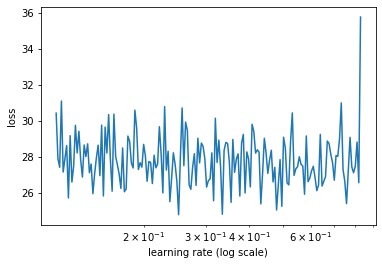

In [0]:
lr_1.plot_loss(n_skip_end=2)

In [0]:
lr_2 = iterate_lr_finder(start_lr=0.001,end_lr=0.1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg

Epoch 1/10
20/20 [==============================] - 10s 508ms/step - loss: 32.6087 - gender_output_loss: 0.6935 - image_quality_output_loss: 1.0969 - age_output_loss: 1.6000 - weight_output_loss: 1.3609 - bag_output_loss: 1.0863 - pose_output_loss: 1.0737 - footwear_output_loss: 1.0977 - emotion_output_loss: 1.3425 - gender_output_weighted_acc: 0.5156 - image_quality_output_weighted_acc: 0.3938 - age_output_weighted_acc: 0.3250 - weight_output_weighted_acc: 0.5563 - bag_output_weighted_acc: 0.4125 - pose_output_weighted_acc: 0.6250 - footwear_output_weighted_acc: 0.3375 - emotion_output_weighted_acc: 0.6594
Epoch 2/10
20/20 [==============================] - 7s 337ms/step - loss: 31.1711 - gender_output_loss: 0.6918 - image_quality_output_loss: 1.0725 - age_output_loss: 1.5493 - weight_output_loss: 1.2653 - bag_output_loss: 1.0442 - pose_output_loss: 1.0237 - footwear_output_loss: 1.0874 - emotion_output_loss: 1.1929 - gender_output_weighted_acc: 0.5781 - image_quality_output_weighted_

In [0]:
lr_3 = iterate_lr_finder(start_lr=0.0001,end_lr=0.001)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg

Epoch 1/10
20/20 [==============================] - 11s 541ms/step - loss: 32.9647 - gender_output_loss: 0.6936 - image_quality_output_loss: 1.0982 - age_output_loss: 1.6099 - weight_output_loss: 1.3808 - bag_output_loss: 1.0904 - pose_output_loss: 1.0950 - footwear_output_loss: 1.0979 - emotion_output_loss: 1.3849 - gender_output_weighted_acc: 0.4688 - image_quality_output_weighted_acc: 0.3531 - age_output_weighted_acc: 0.1437 - weight_output_weighted_acc: 0.2812 - bag_output_weighted_acc: 0.5000 - pose_output_weighted_acc: 0.4281 - footwear_output_weighted_acc: 0.3625 - emotion_output_weighted_acc: 0.2438
Epoch 2/10
20/20 [==============================] - 7s 328ms/step - loss: 32.8812 - gender_output_loss: 0.6934 - image_quality_output_loss: 1.0964 - age_output_loss: 1.6076 - weight_output_loss: 1.3756 - bag_output_loss: 1.0898 - pose_output_loss: 1.0906 - footwear_output_loss: 1.0975 - emotion_output_loss: 1.3752 - gender_output_weighted_acc: 0.4906 - image_quality_output_weighted_

In [0]:
print(lr_finder.get_best_lr(1,1,1))
print(lr_finder.get_best_lr(10,1,1))
print(lr_finder.get_best_lr(20,1,1))

In [0]:
lrs_to_losses = pd.DataFrame({'lrs':lr_finder.lrs, 'losses':lr_finder.losses})
lrs_to_losses.loc[lrs_to_losses.shape[0]-1]
sma_10_lr = lr_finder.get_best_lr(10,1,1)
lrs_to_losses.loc[lrs_to_losses[lrs_to_losses['lrs'].between(sma_10_lr*0.1, sma_10_lr) ]['losses'].idxmin()]

In [0]:
lrs_to_losses

In [0]:
np.min(lr_finder.losses)

In [0]:
print("Max:", np.max(lr_finder.losses),lr_finder.lrs[np.argmax(lr_finder.losses)])
print("Min:", np.min(lr_finder.losses), lr_finder.lrs[np.argmin(lr_finder.losses)])

In [0]:
lr_finder.plot_loss(n_skip_end=1)
#lr_finder.plot_loss(n_skip_end=1,x_scale='linear')

In [0]:
for (k,v) in num_units.items():
    print(k,v)

gender 2
image_quality 3
age 5
weight 4
bag 3
pose 3
footwear 3
emotion 4


In [24]:
#wrn_28_10=create_model()
from keras.models import load_model
# import the necessary packages
from keras.callbacks import BaseLogger
import matplotlib.pyplot as plt
import numpy as np
import json
import os

# class LossHistory(keras.callbacks.Callback):
# 	def on_train_begin(self, logs={}):
# 		print("Clearing saved content on training start")
# 		self.losses = []
# 		self.best = np.Inf

class TrainingMonitor(BaseLogger):
	def __init__(self, figPath, jsonPath=None, startAt=0, backup_hist=True):
		# store the output path for the figure, the path to the JSON
		# serialized file, and the starting epoch
		super(TrainingMonitor, self).__init__()
		self.figPath = figPath
		self.jsonPath = jsonPath
		self.startAt = startAt
		self.backup_hist = backup_hist
		print("JSON path:",self.jsonPath)

	def on_train_begin(self, logs={}):
		# initialize the history dictionary
		self.H = {}
		#self.losses = []

		# if the JSON history path exists, load the training history
		if self.jsonPath is not None:
			if os.path.exists(self.jsonPath) and (self.backup_hist == True):
				#self.H = json.loads(open(self.jsonPath).read())
				backup_file_name=self.jsonPath+str(get_curr_time())+"_backup"
				print("Backing up history file:",self.jsonPath," to:",backup_file_name)
				os.rename(self.jsonPath,backup_file_name) 

				# # check to see if a starting epoch was supplied
				# if self.startAt > 0:
				# 	# loop over the entries in the history log and
				# 	# trim any entries that are past the starting
				# 	# epoch
				# 	for k in self.H.keys():
				# 		self.H[k] = self.H[k][:self.startAt]

	def on_epoch_end(self, epoch, logs={}):
		# loop over the logs and update the loss, accuracy, etc.
		# for the entire training process
		for (k, v) in logs.items():
			l = self.H.get(k, [])
			l.append(float(v))
			self.H[k] = l

		# check to see if the training history should be serialized
		# to file
		if self.jsonPath is not None:
			f = open(self.jsonPath, "w")
			f.write(json.dumps(self.H))
			f.close()
	def on_train_end(self, logs={}):
		backup_file_name=self.jsonPath+str(get_curr_time())+"_backup"
		#print("Backing up history file:",self.jsonPath," to:",backup_file_name)
		os.rename(self.jsonPath,backup_file_name) 
		print("Current JSON PATH:",self.jsonPath)
		print("Final JSON PATH:",backup_file_name)		

import os
plotPath = png_file
jsonPath = json_file
print(plotPath,jsonPath)

/content/gdrive/My Drive/WRN_Extend/png_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.png /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.json


In [0]:
from datetime import datetime
# Prepare model model saving directory.
import os
save_dir = os.path.join('/content/gdrive/', 'My Drive')

model_name = 'assignment5_%s_model.{epoch:03d}.h5' % (model_name_itr+"rd2")
print(model_name)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
# checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_loss',
#                              verbose=1,
# #                              save_best_only=True)

# checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_loss',
#                              verbose=1,
#                              save_best_only=True,mode='min')

assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233rd2_model.{epoch:03d}.h5


In [0]:
EPOCHS=50
#LEARNING_RATE=1.3513402*0.1
#LEARNING_RATE=0.18883973*0.1
#LEARNING_RATE=0.5037587*0.1
LEARNING_RATE=0.020183668*0.15
STEPS_PER_EPOCH=100
test_y = np.linspace(0,EPOCHS,EPOCHS)
x=[0, (EPOCHS+1)//5, EPOCHS]
y=[LEARNING_RATE*0.01, LEARNING_RATE, LEARNING_RATE*0.0001]
interp_lr = np.interp(test_y, x, y)
def one_lr_schedule(epoch):
    # if(epoch <= 15):
    #     print("lr:",interp_lr[epoch+84],epoch)
    #     return interp_lr[epoch+84]
    print("lr:",interp_lr[epoch],epoch)
    return interp_lr[epoch]
#interp_values = np.interp(, [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])
lr_scheduler = LearningRateScheduler(one_lr_schedule)
# callbacks = [checkpoint, lr_scheduler,TrainingMonitor(figPath=plotPath,
#                                                       jsonPath=jsonPath,startAt=2)]
callbacks = [checkpoint, clr,TrainingMonitor(figPath=plotPath,
                                                      jsonPath=jsonPath,startAt=0)]

In [0]:
save_dir = os.path.join('/content/gdrive/', 'My Drive/WRN_Extend')


def generate_new_callbacks(steps_per_epoch=50,
                           epoch_count=50,
                           min_lr=0.00001, 
                           max_lr=0.1,
                           patience=25,
                           check_point=True,
                           clr_mode='triangular',
                           clr_multiplier=4):
    model_name = 'assignment5_%s_model.{epoch:03d}.h5' % (model_name_itr+"_"+str(get_curr_time()))
    print(model_name)
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)
    local_clr = CyclicLR(base_lr=min_lr,
                            max_lr=max_lr,
                            step_size=steps_per_epoch*clr_multiplier,
                            mode=clr_mode)

    training_mon = TrainingMonitor(figPath=plotPath,
                                   jsonPath=jsonPath,
                                   startAt=0)
    ########## Introduced after 2x100 Epochs
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=patience, 
                                                    restore_best_weights=True)
    print("Returning new callback array with steps_per_epoch=",steps_per_epoch,
          "min_lr=",min_lr,
          "max_lr=",max_lr,
          "epoch_count=",epoch_count,
          "patience=",patience
          )
    callback_array = [local_clr, early_stop,training_mon]
    if(check_point == True):
        checkpoint = ModelCheckpoint(filepath=filepath,
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min')
        callback_array.append(checkpoint)
    
    return callback_array

In [26]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.callbacks import CyclicLR


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-soxqqh64
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-soxqqh64
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=3652db5e80a58fe2b0e65cd94b3f2aa188a5c6d4df7e5abdfedc77606abc7ce4
  Stored in directory: /tmp/pip-ephem-wheel-cache-utt2zxb6/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
loss_weights_train

{'age_output': {0: 2.172, 1: 1.0, 2: 1.589, 3: 3.556, 4: 7.326},
 'bag_output': {0: 1.667, 1: 5.837, 2: 1.0},
 'emotion_output': {0: 6.454, 1: 6.05, 2: 1.0, 3: 12.056},
 'footwear_output': {0: 1.23, 1: 2.38, 2: 1.0},
 'gender_output': {0: 1.304, 1: 1.0},
 'imagequality_ouput': {0: 1.0, 1: 3.361, 2: 1.979},
 'pose_output': {0: 3.836, 1: 1.0, 2: 2.786},
 'weight_output': {0: 1.0, 1: 9.632, 2: 2.753, 3: 9.931}}

In [0]:
def run_model_iterations(model,
                         re_compile=True,
                         epoch_count=50, 
                         steps_per_epoch=50, 
                         min_lr=LEARNING_RATE*0.01, 
                         max_lr=LEARNING_RATE,
                         loss_weights_compile={},
                         loss_weights_train={}                         
                         ):


    if re_compile == True:
        model.compile(
            #optimizer=SGD(lr=1.3513402*0.1),
            optimizer=SGD(lr=min_lr),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            loss_weights=loss_weights_compile,
            #weighted_metrics=["accuracy"]
            metrics=["accuracy"]
        )
    model.fit_generator(
        generator=train_gen,
        validation_data=valid_gen,
        use_multiprocessing=True,
        workers=4, 
        epochs=1,
        verbose=1,
        class_weight=loss_weights_train,
        steps_per_epoch=steps_per_epoch,
        callbacks=generate_new_callbacks(steps_per_epoch=steps_per_epoch, min_lrm=in_lr, max_lr=max_lr, epoch_count=epoch_count)
    )


In [0]:
wrn_28_10=create_model()
run_model_iterations(wrn_28_10,
                    re_compile=True,
                    epoch_count=1, 
                    steps_per_epoch=1, 
                    min_lr=LEARNING_RATE*0.01, 
                    max_lr=LEARNING_RATE,
                    loss_weights_compile={},
                    loss_weights_train={})

In [0]:
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model()
wrn_28_10=create_model()
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=30
EPOCHS=100
loss_weights_compile = {'gender_output': 2, 
                        'image_quality_output': 2, 
                        'age_output': 4, 
                        'weight_output': 3, 
                        'bag_output': 3, 
                        'pose_output': 3, 
                        'footwear_output': 2, 
                        'emotion_output': 4}

wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4, 
    epochs=EPOCHS,
    verbose=1,
    class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg

JSON path: /content/gdrive/My Drive/json_wrn2_rkg_fresh_wrn_1577517949.json
Returning new callback array with steps_per_epoch= 30 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 100
Epoch 1/100
30/30 [==============================] - 30s 1s/step - loss: 57.5037 - gender_output_loss: 0.7785 - image_quality_output_loss: 1.0708 - age_output_loss: 3.3000 - weight_output_loss: 3.0777 - bag_output_loss: 1.7404 - pose_output_loss: 1.8278 - footwear_output_loss: 1.4480 - emotion_output_loss: 3.3142 - gender_output_acc: 0.5583 - image_quality_output_acc: 0.4437 - age_output_acc: 0.3167 - weight_output_acc: 0.5875 - bag_output_acc: 0.4729 - pose_output_acc: 0.6062 - footwear_output_acc: 0.4417 - emotion_output_acc: 0.7021 - val_loss: 28.0711 - val_gender_output_loss: 0.6933 - val_image_quality_output_loss: 1.0056 - val_age_output_loss: 1.4338 - val_weight_output_loss: 1.0216 - val_bag_output_loss: 0.9297 - val_pose_output_loss: 0.9306 - val_footwear_output_loss: 1.0471 - val_emotion_output

In [0]:
print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)

End of EPOCHS= 100  STEPS_PER_EPOCH= 30


In [0]:
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model()
wrn_28_10=create_model()
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=100
EPOCHS=100
# loss_weights_compile = {'gender_output': 2, 
#                         'image_quality_output': 2, 
#                         'age_output': 4, 
#                         'weight_output': 3, 
#                         'bag_output': 3, 
#                         'pose_output': 3, 
#                         'footwear_output': 2, 
#                         'emotion_output': 4}



wrn_28_10.load_weights('/content/gdrive/My Drive/assignment5_wrn2_rkg_fresh_wrn_1577517949rd2_model.097.h5')
wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4, 
    epochs=EPOCHS,
    verbose=1,
    class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg

JSON path: /content/gdrive/My Drive/json_wrn2_rkg_fresh_wrn_1577517949.json
Returning new callback array with steps_per_epoch= 100 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 100
Backing up history file: /content/gdrive/My Drive/json_wrn2_rkg_fresh_wrn_1577517949.json  to: /content/gdrive/My Drive/json_wrn2_rkg_fresh_wrn_1577517949.json1577524781_backup
Epoch 1/100
  2/100 [..............................] - ETA: 6:38 - loss: 66.1505 - gender_output_loss: 0.6945 - image_quality_output_loss: 0.9638 - age_output_loss: 3.0244 - weight_output_loss: 3.8865 - bag_output_loss: 1.9364 - pose_output_loss: 2.0708 - footwear_output_loss: 1.4651 - emotion_output_loss: 5.0548 - gender_output_acc: 0.6562 - image_quality_output_acc: 0.5312 - age_output_acc: 0.3438 - weight_output_acc: 0.5312 - bag_output_acc: 0.5312 - pose_output_acc: 0.5625 - footwear_output_acc: 0.4688 - emotion_output_acc: 0.5625 

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.305855). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 56s 565ms/step - loss: 50.3948 - gender_output_loss: 0.7389 - image_quality_output_loss: 0.9720 - age_output_loss: 2.7361 - weight_output_loss: 2.5943 - bag_output_loss: 1.6506 - pose_output_loss: 1.7314 - footwear_output_loss: 1.3285 - emotion_output_loss: 2.8846 - gender_output_acc: 0.6169 - image_quality_output_acc: 0.5537 - age_output_acc: 0.4050 - weight_output_acc: 0.6556 - bag_output_acc: 0.5706 - pose_output_acc: 0.6219 - footwear_output_acc: 0.5356 - emotion_output_acc: 0.7000 - val_loss: 26.6551 - val_gender_output_loss: 0.6432 - val_image_quality_output_loss: 0.9832 - val_age_output_loss: 1.3921 - val_weight_output_loss: 0.9769 - val_bag_output_loss: 0.9025 - val_pose_output_loss: 0.9135 - val_footwear_output_loss: 0.9425 - val_emotion_output_loss: 0.9174 - val_gender_output_acc: 0.6093 - val_image_quality_output_acc: 0.5453 - val_age_output_acc: 0.4006 - val_weight_output_acc: 0.6230 - val_bag_output_acc: 0.5600 - val_pose_output_a

In [0]:
print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)

End of EPOCHS= 100  STEPS_PER_EPOCH= 100


In [0]:
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model()
STEPS_PER_EPOCH=200
EPOCHS=100

#wrn_28_10=create_model()
wrn_28_10.load_weights('/content/gdrive/My Drive/assignment5_wrn2_rkg_fresh_wrn_1577517949rd2_model.097.h5')
loss_weights_compile = {'gender_output': 2, 
                        'image_quality_output': 2, 
                        'age_output': 4, 
                        'weight_output': 3, 
                        'bag_output': 3, 
                        'pose_output': 3, 
                        'footwear_output': 2, 
                        'emotion_output': 4}




wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4, 
    epochs=EPOCHS,
    verbose=1,
    class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)

JSON path: /content/gdrive/My Drive/json_wrn2_rkg_fresh_wrn_1577517949.json
Returning new callback array with steps_per_epoch= 200 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 100
Backing up history file: /content/gdrive/My Drive/json_wrn2_rkg_fresh_wrn_1577517949.json  to: /content/gdrive/My Drive/json_wrn2_rkg_fresh_wrn_1577517949.json1577531556_backup
Epoch 1/100
  2/200 [..............................] - ETA: 14:12 - loss: 45.5879 - gender_output_loss: 0.8115 - image_quality_output_loss: 0.9669 - age_output_loss: 2.5192 - weight_output_loss: 2.1223 - bag_output_loss: 1.9821 - pose_output_loss: 1.4867 - footwear_output_loss: 1.1765 - emotion_output_loss: 2.2305 - gender_output_acc: 0.5938 - image_quality_output_acc: 0.5625 - age_output_acc: 0.4062 - weight_output_acc: 0.7188 - bag_output_acc: 0.5625 - pose_output_acc: 0.6875 - footwear_output_acc: 0.5625 - emotion_output_acc: 0.7188

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.360489). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


200/200 [==============================] - 90s 449ms/step - loss: 50.0542 - gender_output_loss: 0.7402 - image_quality_output_loss: 0.9742 - age_output_loss: 2.7943 - weight_output_loss: 2.7127 - bag_output_loss: 1.5901 - pose_output_loss: 1.7832 - footwear_output_loss: 1.3115 - emotion_output_loss: 2.6662 - gender_output_acc: 0.6122 - image_quality_output_acc: 0.5553 - age_output_acc: 0.4019 - weight_output_acc: 0.6278 - bag_output_acc: 0.5672 - pose_output_acc: 0.6081 - footwear_output_acc: 0.5438 - emotion_output_acc: 0.7194 - val_loss: 26.6649 - val_gender_output_loss: 0.6392 - val_image_quality_output_loss: 0.9820 - val_age_output_loss: 1.4015 - val_weight_output_loss: 0.9814 - val_bag_output_loss: 0.8986 - val_pose_output_loss: 0.9117 - val_footwear_output_loss: 0.9372 - val_emotion_output_loss: 0.9178 - val_gender_output_acc: 0.6161 - val_image_quality_output_acc: 0.5453 - val_age_output_acc: 0.4045 - val_weight_output_acc: 0.6230 - val_bag_output_acc: 0.5595 - val_pose_output_a

In [0]:
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model()
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=train_df.shape[0]//BATCH_SIZE
EPOCHS=30

wrn_28_10=create_model()
wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_1577517949rd2_model.096.h5')
loss_weights_compile = {'gender_output': 2, 
                        'image_quality_output': 2, 
                        'age_output': 4, 
                        'weight_output': 3, 
                        'bag_output': 3, 
                        'pose_output': 3, 
                        'footwear_output': 2, 
                        'emotion_output': 4}

wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4, 
    epochs=EPOCHS,
    verbose=1,
    class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg

assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577543864.json
Returning new callback array with steps_per_epoch= 721 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 30 patience= 25


Epoch 1/30
721/721 [==============================] - 255s 354ms/step - loss: 45.0893 - gender_output_loss: 0.6022 - image_quality_output_loss: 0.9381 - age_output_loss: 2.8012 - weight_output_loss: 2.5911 - bag_output_loss: 1.5010 - pose_output_loss: 1.2641 - footwear_output_loss: 1.1996 - emotion_output_loss: 2.6607 - gender_output_acc: 0.7301 - image_quality_output_acc: 0.5567 - age_output_acc: 0.4013 - weight_output_acc: 0.6384 - bag_output_acc: 0.6073 - pose_output_acc: 0.7146 - footwear_output_acc: 0.5898 - emotion_output_acc: 0.7119 - val_loss: 22.6609 - val_gender_output_loss: 0.4913 - val_image_quality_output_loss: 0.9354 - val_age_output_loss: 1.3775 - val_weight_output_loss: 0.9829 -

In [0]:
wrn_28_10.save("/content/gdrive/My Drive/WRN_Extend/model_8233acc.h5py")

In [0]:
aug_gen_array = [ ImageDataGenerator(horizontal_flip=True, 
                             vertical_flip=False,
                             rotation_range=5,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=[0.5,2.5],
                             shear_range=0.2,
                             #zca_whitening=True,
                             brightness_range=[0.5,2.5],
                             #preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False)
                             ),
           ImageDataGenerator(horizontal_flip=True, 
                             vertical_flip=False,
                             rotation_range=30,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=[0.5,2.5],
                             shear_range=0.2,
                             #zca_whitening=True,
                             brightness_range=[0.5,2.5],
                             #preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False)
                             ),
           ImageDataGenerator(horizontal_flip=True, 
                             vertical_flip=False,
                             rotation_range=5,
                             width_shift_range=0.5,
                             height_shift_range=0.5,
                             zoom_range=[0.5,2.5],
                             shear_range=0.2,
                             #zca_whitening=True,
                             brightness_range=[0.5,2.5],
                             #preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False)
                             ),
           ImageDataGenerator(horizontal_flip=True, 
                             vertical_flip=False,
                             rotation_range=5,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=[0.5,3.5],
                             shear_range=0.2,
                             #zca_whitening=True,
                             brightness_range=[0.5,2.5],
                             #preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False)
                             ),
           ImageDataGenerator(horizontal_flip=True, 
                             vertical_flip=False,
                             rotation_range=5,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=[0.5,3.5],
                             shear_range=0.2,
                             #zca_whitening=True,
                             brightness_range=[0.5,2.5],
                             #preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False)
                             ),
           ImageDataGenerator(horizontal_flip=True, 
                             vertical_flip=False,
                             rotation_range=5,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=[0.5,2.5],
                             shear_range=0.8,
                             #zca_whitening=True,
                             brightness_range=[0.5,4.5],
                             #preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False)
                             ),
           ImageDataGenerator(horizontal_flip=True, 
                             vertical_flip=False,
                             rotation_range=5,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=[0.5,2.5],
                             shear_range=0.2,
                             #zca_whitening=True,
                             brightness_range=[0.5,2.5],
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False)
                             )
]
           

In [0]:
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model()
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=30
EPOCHS=50

#wrn_28_10=create_model()
# aug_gen = ImageDataGenerator(horizontal_flip=True, 
#                              vertical_flip=False,
#                              rotation_range=5,
#                              width_shift_range=0.1,
#                              height_shift_range=0.1,
#                              zoom_range=[0.5,2.5],
#                              shear_range=0.2,
#                              #zca_whitening=True,
#                              brightness_range=[0.5,2.5],
#                              #preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False)
#                              )
from keras.models import load_model
for aug_gen_count in range(len(aug_gen_array)):
    print("Executing augmentation",aug_gen_count)
    new_model = create_model()
    new_model.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5')
    
    train_gen = PersonDataGenerator(train_df, 
                                    batch_size=BATCH_SIZE,
                                    normalize=True,
                                    aug_flow=aug_gen_array[aug_gen_count])
    valid_gen = PersonDataGenerator(val_df, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False,normalize=True)

    #wrn_28_10.load_weights()

    loss_weights_compile = {'gender_output': 2, 
                            'image_quality_output': 2, 
                            'age_output': 4, 
                            'weight_output': 3, 
                            'bag_output': 3, 
                            'pose_output': 3, 
                            'footwear_output': 2, 
                            'emotion_output': 4}

    new_model.compile(
        #optimizer=SGD(lr=1.3513402*0.1),
        optimizer=SGD(lr=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        loss_weights=loss_weights_compile,
        #weighted_metrics=["accuracy"]
        metrics=["accuracy"]
    )
    callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                        epoch_count=EPOCHS,
                                        min_lr=LEARNING_RATE*0.01, 
                                        max_lr=LEARNING_RATE,
                                        patience=10, check_point=False)
    #print(callbacks)
    new_model.fit_generator(
        generator=train_gen,
        validation_data=valid_gen,
        use_multiprocessing=True,
        workers=4, 
        epochs=EPOCHS,
        verbose=1,
        class_weight=loss_weights_train,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=callbacks
    )
    del new_model
    print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)

    

Executing augmentation 0









/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", strides=(2, 2), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`



assignment5_wrn2_rkg_fresh_wrn_wide_1577560074_1577560164_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json
Returning new callback array with steps_per_epoch= 30 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 50 patience= 10


Epoch 1/50
30/30 [==============================] - 32s 1s/step - loss: 39.1244 - gender_output_loss: 0.5328 - image_quality_output_loss: 0.9263 - age_output_loss: 2.5475 - weight_output_loss: 2.1897 - bag_output_loss: 1.4486 - pose_output_loss: 1.0365 - footwear_output_loss: 1.1665 - emotion_output_loss: 2.1119 - gender_output_acc: 0.7729 - image_quality_output_acc: 0.5625 - age_output_acc: 0.4292 - weight_output_acc: 0.6812 - bag_output_acc: 0.6375 - pose_output_acc: 0.7937 - footwear_output_acc: 0.6042 - emotion_output_acc: 0.7396 - val_loss: 21.5024 - val_gender_output_loss: 0.4111 - val_image_quality_output_loss: 0.9370 - val_age_output_loss: 1.3576 - val_weight_output_loss: 0.9819 - val_b

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg

assignment5_wrn2_rkg_fresh_wrn_wide_1577560074_1577560453_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json
Returning new callback array with steps_per_epoch= 30 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 50 patience= 10
Backing up history file: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json  to: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json1577560456_backup
Epoch 1/50
30/30 [==============================] - 30s 989ms/step - loss: 44.6495 - gender_output_loss: 0.6268 - image_quality_output_loss: 0.9016 - age_output_loss: 2.7483 - weight_output_loss: 2.1701 - bag_output_loss: 1.5656 - pose_output_loss: 1.3120 - footwear_output_loss: 1.1509 - emotion_output_loss: 2.9858 - gender_output_acc: 0.7063 - image_quality_output_acc: 0.5958 - age_output_acc: 0.4250 - weight_output_acc: 0.6583 - bag_output_acc: 0.6104 - pose_output_acc: 0.6667 - footwear_ou

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg

assignment5_wrn2_rkg_fresh_wrn_wide_1577560074_1577560963_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json
Returning new callback array with steps_per_epoch= 30 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 50 patience= 10
Backing up history file: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json  to: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json1577560966_backup
Epoch 1/50
30/30 [==============================] - 31s 1s/step - loss: 49.6529 - gender_output_loss: 0.7112 - image_quality_output_loss: 0.9455 - age_output_loss: 2.8625 - weight_output_loss: 2.8561 - bag_output_loss: 1.4186 - pose_output_loss: 1.5531 - footwear_output_loss: 1.3323 - emotion_output_loss: 3.3825 - gender_output_acc: 0.6271 - image_quality_output_acc: 0.5500 - age_output_acc: 0.3958 - weight_output_acc: 0.6333 - bag_output_acc: 0.5708 - pose_output_acc: 0.6250 - footwear_outpu

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg

assignment5_wrn2_rkg_fresh_wrn_wide_1577560074_1577561463_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json
Returning new callback array with steps_per_epoch= 30 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 50 patience= 10
Backing up history file: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json  to: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json1577561466_backup
Epoch 1/50
30/30 [==============================] - 32s 1s/step - loss: 45.0069 - gender_output_loss: 0.5238 - image_quality_output_loss: 0.9309 - age_output_loss: 2.9842 - weight_output_loss: 2.6719 - bag_output_loss: 1.5194 - pose_output_loss: 1.2010 - footwear_output_loss: 1.2212 - emotion_output_loss: 2.5826 - gender_output_acc: 0.7896 - image_quality_output_acc: 0.5813 - age_output_acc: 0.3917 - weight_output_acc: 0.6458 - bag_output_acc: 0.6187 - pose_output_acc: 0.7500 - footwear_outpu

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg

assignment5_wrn2_rkg_fresh_wrn_wide_1577560074_1577562023_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json
Returning new callback array with steps_per_epoch= 30 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 50 patience= 10
Backing up history file: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json  to: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json1577562027_backup
Epoch 1/50
30/30 [==============================] - 33s 1s/step - loss: 44.9443 - gender_output_loss: 0.5756 - image_quality_output_loss: 0.9097 - age_output_loss: 2.9368 - weight_output_loss: 2.3411 - bag_output_loss: 1.5718 - pose_output_loss: 1.0564 - footwear_output_loss: 1.2450 - emotion_output_loss: 2.9043 - gender_output_acc: 0.7542 - image_quality_output_acc: 0.5750 - age_output_acc: 0.4000 - weight_output_acc: 0.6479 - bag_output_acc: 0.5771 - pose_output_acc: 0.7604 - footwear_outpu

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg

assignment5_wrn2_rkg_fresh_wrn_wide_1577560074_1577562708_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json
Returning new callback array with steps_per_epoch= 30 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 50 patience= 10
Backing up history file: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json  to: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json1577562712_backup
Epoch 1/50
30/30 [==============================] - 32s 1s/step - loss: 46.4128 - gender_output_loss: 0.5475 - image_quality_output_loss: 0.9322 - age_output_loss: 3.0747 - weight_output_loss: 2.5077 - bag_output_loss: 1.4116 - pose_output_loss: 1.2123 - footwear_output_loss: 1.1285 - emotion_output_loss: 3.0729 - gender_output_acc: 0.7688 - image_quality_output_acc: 0.5667 - age_output_acc: 0.4104 - weight_output_acc: 0.6208 - bag_output_acc: 0.6458 - pose_output_acc: 0.7271 - footwear_outpu

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg

assignment5_wrn2_rkg_fresh_wrn_wide_1577560074_1577563000_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json
Returning new callback array with steps_per_epoch= 30 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 50 patience= 10
Backing up history file: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json  to: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_1577560074.json1577563005_backup
Epoch 1/50
 2/30 [=>............................] - ETA: 1:52 - loss: 39.8045 - gender_output_loss: 0.5389 - image_quality_output_loss: 0.9091 - age_output_loss: 2.0819 - weight_output_loss: 2.4273 - bag_output_loss: 1.1621 - pose_output_loss: 1.5508 - footwear_output_loss: 0.9768 - emotion_output_loss: 2.4988 - gender_output_acc: 0.6875 - image_quality_output_acc: 0.5938 - age_output_acc: 0.5312 - weight_output_acc: 0.6250 - bag_output_acc: 0.8125 - pose_output_acc: 0.6875 - footwear_output_

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.315896). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


30/30 [==============================] - 32s 1s/step - loss: 42.5249 - gender_output_loss: 0.5707 - image_quality_output_loss: 0.9611 - age_output_loss: 2.6590 - weight_output_loss: 2.3120 - bag_output_loss: 1.5027 - pose_output_loss: 1.2860 - footwear_output_loss: 1.2183 - emotion_output_loss: 2.4689 - gender_output_acc: 0.7354 - image_quality_output_acc: 0.5167 - age_output_acc: 0.4333 - weight_output_acc: 0.6542 - bag_output_acc: 0.6146 - pose_output_acc: 0.7250 - footwear_output_acc: 0.6062 - emotion_output_acc: 0.7271 - val_loss: 21.5265 - val_gender_output_loss: 0.4178 - val_image_quality_output_loss: 0.9393 - val_age_output_loss: 1.3575 - val_weight_output_loss: 0.9910 - val_bag_output_loss: 0.8336 - val_pose_output_loss: 0.5021 - val_footwear_output_loss: 0.8066 - val_emotion_output_loss: 0.8944 - val_gender_output_acc: 0.8169 - val_image_quality_output_acc: 0.5453 - val_age_output_acc: 0.3932 - val_weight_output_acc: 0.5969 - val_bag_output_acc: 0.6447 - val_pose_output_acc: 0

In [0]:
###################### Couldn't find a good augmentation strategy hence sticking with defaults ##################
################# Tweaking weights #################
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model()
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=30
EPOCHS=100
#"/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5"
wrn_28_10=create_model()
wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5')
loss_weights_compile = {'gender_output': 2, 
                        'image_quality_output': 2, 
                        'age_output': 6, 
                        'weight_output': 3, 
                        'bag_output': 5, 
                        'pose_output': 4, 
                        'footwear_output': 4, 
                        'emotion_output': 4}

wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4, 
    epochs=EPOCHS,
    verbose=1,
    class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)

###################### loss on weight change ################
#[-0.0207 -0.0044  0.0069  0.0108 -0.0015 -0.0098 -0.0089 -0.0103]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg..



assignment5_wrn2_rkg_fresh_wrn_wide_rjy_1577567748_1577567987_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy_1577567748.json
Returning new callback array with steps_per_epoch= 30 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 100 patience= 25


Epoch 1/100
30/30 [==============================] - 36s 1s/step - loss: 51.4479 - gender_output_loss: 0.5275 - image_quality_output_loss: 0.9745 - age_output_loss: 2.5789 - weight_output_loss: 2.3144 - bag_output_loss: 1.3235 - pose_output_loss: 1.0347 - footwear_output_loss: 1.1220 - emotion_output_loss: 2.3929 - gender_output_acc: 0.7833 - image_quality_output_acc: 0.5271 - age_output_acc: 0.4313 - weight_output_acc: 0.6708 - bag_output_acc: 0.6375 - pose_output_acc: 0.7792 - footwear_output_acc: 0.6167 - emotion_output_acc: 0.7229 - val_loss: 28.2428 - val_gender_output_loss: 0.4263 - val_image_quality_output_loss: 0.9211 - val_age_output_loss: 1.3731 - val_weight_output_loss: 0.9

In [0]:
###################### Couldn't find a good augmentation strategy hence sticking with defaults ##################
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model()
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=train_df.shape[0]//BATCH_SIZE
EPOCHS=100
#"/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5"
wrn_28_10=create_model()
wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5')
# loss_weights_compile = {'gender_output': 2, 
#                         'image_quality_output': 2, 
#                         'age_output': 6, 
#                         'weight_output': 3, 
#                         'bag_output': 5, 
#                         'pose_output': 4, 
#                         'footwear_output': 4, 
#                         'emotion_output': 4}
loss_weights_compile = {'gender_output': 2, 
                        'image_quality_output': 2, 
                        'age_output': 4, 
                        'weight_output': 3, 
                        'bag_output': 3, 
                        'pose_output': 3, 
                        'footwear_output': 2, 
                        'emotion_output': 4}


wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE,
                                   patience=15)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4, 
    epochs=EPOCHS,
    verbose=1,
    #class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg

assignment5_wrn2_rkg_fresh_wrn_wide_rjy_1577567748_1577569953_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy_1577567748.json
Returning new callback array with steps_per_epoch= 721 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 100 patience= 15
Backing up history file: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy_1577567748.json  to: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy_1577567748.json1577569955_backup
Epoch 1/100
721/721 [==============================] - 245s 340ms/step - loss: 21.4726 - gender_output_loss: 0.4474 - image_quality_output_loss: 0.9209 - age_output_loss: 1.3485 - weight_output_loss: 0.9524 - bag_output_loss: 0.8241 - pose_output_loss: 0.5478 - footwear_output_loss: 0.8502 - emotion_output_loss: 0.8652 - gender_output_acc: 0.7931 - image_quality_output_acc: 0.5625 - age_output_acc: 0.4074 - weight_output_acc: 0.6386 - bag_output_acc: 0.6370 - pose_output_acc

In [0]:
###################### Couldn't find a good augmentation strategy hence sticking with defaults ##################
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model()
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=360 #train_df.shape[0]//BATCH_SIZE
EPOCHS=100
#"/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5"
wrn_28_10=create_model()
#wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5')
wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy_1577567748_1577569953_model.006.h5')
# loss_weights_compile = {'gender_output': 2, 
#                         'image_quality_output': 2, 
#                         'age_output': 6, 
#                         'weight_output': 3, 
#                         'bag_output': 5, 
#                         'pose_output': 4, 
#                         'footwear_output': 4, 
#                         'emotion_output': 4}
loss_weights_compile = {'gender_output': 2, 
                        'image_quality_output': 2, 
                        'age_output': 4, 
                        'weight_output': 3, 
                        'bag_output': 3, 
                        'pose_output': 3, 
                        'footwear_output': 2, 
                        'emotion_output': 4}


wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE,
                                   patience=15)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4, 
    epochs=EPOCHS,
    verbose=1,
    #class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg..



assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577594387_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233.json
Returning new callback array with steps_per_epoch= 360 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 100 patience= 15


Epoch 1/100
360/360 [==============================] - 148s 410ms/step - loss: 21.0283 - gender_output_loss: 0.3992 - image_quality_output_loss: 0.9037 - age_output_loss: 1.3409 - weight_output_loss: 0.9509 - bag_output_loss: 0.8176 - pose_output_loss: 0.5180 - footwear_output_loss: 0.8282 - emotion_output_loss: 0.8796 - gender_output_acc: 0.8220 - image_quality_output_acc: 0.5743 - age_output_acc: 0.4113 - weight_output_acc: 0.6354 - bag_output_acc: 0.6403 - pose_output_acc: 0.7943 - footwear_output_acc: 0.6319 - emotion_output_acc: 0.7030 - val_loss: 22.0890 - val_gender_output_loss: 0.3933 - val_image_quality_output_loss: 1.2126 - val_age_output_loss: 1.3536 - val_weight_output_

In [0]:
###################### Couldn't find a good augmentation strategy hence sticking with defaults ##################
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model()
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=train_df.shape[0]//BATCH_SIZE
EPOCHS=300
#"/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5"
#wrn_28_10=create_model()
#wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5')
wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577594387_model.024.h5')
# loss_weights_compile = {'gender_output': 2, 
#                         'image_quality_output': 2, 
#                         'age_output': 6, 
#                         'weight_output': 3, 
#                         'bag_output': 5, 
#                         'pose_output': 4, 
#                         'footwear_output': 4, 
#                         'emotion_output': 4}
loss_weights_compile = {'gender_output': 2, 
                        'image_quality_output': 2, 
                        'age_output': 4, 
                        'weight_output': 3, 
                        'bag_output': 3, 
                        'pose_output': 3, 
                        'footwear_output': 2, 
                        'emotion_output': 4}


wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE,
                                   patience=50)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4,
    epochs=EPOCHS,
    verbose=1,
    #class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)


assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577603312_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233.json
Returning new callback array with steps_per_epoch= 721 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 300 patience= 50
Backing up history file: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233.json  to: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233.json1577603315_backup
Epoch 1/300
721/721 [==============================] - 244s 339ms/step - loss: 20.3378 - gender_output_loss: 0.3662 - image_quality_output_loss: 0.8943 - age_output_loss: 1.3116 - weight_output_loss: 0.9392 - bag_output_loss: 0.7967 - pose_output_loss: 0.4909 - footwear_output_loss: 0.8180 - emotion_output_loss: 0.8536 - gender_output_acc: 0.8370 - image_quality_output_acc: 0.5726 - age_output_acc: 0.4209 - weight_output_acc: 0.6393 - bag_output_acc: 0.6553 - pose_output

Process ForkPoolWorker-772:
Process ForkPoolWorker-769:
Process ForkPoolWorker-771:
Process ForkPoolWorker-770:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-767:
Process ForkPoolWorker-765:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-766:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-768:
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.

KeyboardInterrupt: ignored

In [0]:
import glob
def get_latestn_files(path = "/content/gdrive/My Drive/WRN_Extend/", pattern="*.json",count=2):
    #path = "/content/gdrive/My Drive/WRN_Extend/"
    file_path = os.path.join(path)+pattern
    files = [f for f in glob.iglob(file_path, recursive=False)]
    latest_file = sorted(files, key=os.path.getctime,reverse=True)
    return latest_file[:count]
#files = os.listdir(path)
#filenamere.split(r'/',files[len(files)-1])

In [0]:
get_latestn_files(path = "/content/gdrive/My Drive/WRN_Extend/", pattern="*.h5",count=1)

['/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577603312_model.048.h5']

In [0]:
########## Stopped previous run on Account of overfitting ##############
######### Start run with increased dropout

###################### Couldn't find a good augmentation strategy hence sticking with defaults ##################
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
wrn_28_10=create_model(dropout=0.1)
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=train_df.shape[0]//BATCH_SIZE
EPOCHS=10
#"/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5"
#wrn_28_10=create_model()
#wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5')
last_saved_file = get_latestn_files(path = "/content/gdrive/My Drive/WRN_Extend/", pattern="*.h5",count=1)
wrn_28_10.load_weights(last_saved_file[0])
# loss_weights_compile = {'gender_output': 2, 
#                         'image_quality_output': 2, 
#                         'age_output': 6, 
#                         'weight_output': 3, 
#                         'bag_output': 5, 
#                         'pose_output': 4, 
#                         'footwear_output': 4, 
#                         'emotion_output': 4}
loss_weights_compile = {'gender_output': 2, 
                        'image_quality_output': 2, 
                        'age_output': 4, 
                        'weight_output': 3, 
                        'bag_output': 3, 
                        'pose_output': 3, 
                        'footwear_output': 2, 
                        'emotion_output': 4}


wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE,
                                   patience=10)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4,
    epochs=EPOCHS,
    verbose=1,
    #class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg

assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577618033_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233.json
Returning new callback array with steps_per_epoch= 721 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 10 patience= 10
Backing up history file: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233.json  to: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233.json1577618037_backup
Epoch 1/10
721/721 [==============================] - 248s 344ms/step - loss: 19.3692 - gender_output_loss: 0.3011 - image_quality_output_loss: 0.8745 - age_output_loss: 1.2492 - weight_output_loss: 0.9110 - bag_output_loss: 0.7575 - pose_output_loss: 0.4355 - footwear_output_loss: 0.7860 - emotion_output_loss: 0.8419 - gender_output_acc: 0.8701 - image_quality_output_acc: 0.5822 - age_output_acc: 0.4459 - weight_output_acc: 0.6468 - bag_output_acc: 0.6815 - pose_output_a

In [0]:
########## Stopped previous run on Account of overfitting ##############
######### Start run with increased dropout

###################### Couldn't find a good augmentation strategy hence sticking with defaults ##################
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model(dropout=0.1)
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=train_df.shape[0]//BATCH_SIZE//2
EPOCHS=10
#"/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5"
#wrn_28_10=create_model()
#wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5')
last_saved_file = get_latestn_files(path = "/content/gdrive/My Drive/WRN_Extend/", pattern="*.h5",count=1)
print(last_saved_file[0])
wrn_28_10.load_weights(last_saved_file[0])
# loss_weights_compile = {'gender_output': 2, 
#                         'image_quality_output': 2, 
#                         'age_output': 6, 
#                         'weight_output': 3, 
#                         'bag_output': 5, 
#                         'pose_output': 4, 
#                         'footwear_output': 4, 
#                         'emotion_output': 4}
loss_weights_compile = {'gender_output': 2, 
                        'image_quality_output': 2, 
                        'age_output': 4, 
                        'weight_output': 3, 
                        'bag_output': 3, 
                        'pose_output': 3, 
                        'footwear_output': 2, 
                        'emotion_output': 4}


wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE,
                                   patience=10)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4,
    epochs=EPOCHS,
    verbose=1,
    #class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)


/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577618033_model.009.h5
assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577621486_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233.json
Returning new callback array with steps_per_epoch= 360 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 10 patience= 10
Epoch 1/10
360/360 [==============================] - 135s 374ms/step - loss: 19.3736 - gender_output_loss: 0.3038 - image_quality_output_loss: 0.8809 - age_output_loss: 1.2445 - weight_output_loss: 0.9062 - bag_output_loss: 0.7561 - pose_output_loss: 0.4332 - footwear_output_loss: 0.7853 - emotion_output_loss: 0.8453 - gender_output_acc: 0.8703 - image_quality_output_acc: 0.5776 - age_output_acc: 0.4550 - weight_output_acc: 0.6483 - bag_output_acc: 0.6844 - pose_output_acc: 0.8274 - footwear_output_acc: 0.6460 - emotion_output_acc: 0.7123 - val_loss: 20.5468 - val_gender_outp

In [0]:
########## Stopped previous run on Account of overfitting ##############
######### Start run with increased dropout

###################### Couldn't find a good augmentation strategy hence sticking with defaults ##################
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model(dropout=0.1)
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=train_df.shape[0]//BATCH_SIZE//2
EPOCHS=20
#"/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5"
#wrn_28_10=create_model()
#wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5')
last_saved_file = get_latestn_files(path = "/content/gdrive/My Drive/WRN_Extend/", pattern="*.h5",count=1)
print(last_saved_file[0])
wrn_28_10.load_weights(last_saved_file[0])
# loss_weights_compile = {'gender_output': 2, 
#                         'image_quality_output': 2, 
#                         'age_output': 6, 
#                         'weight_output': 3, 
#                         'bag_output': 5, 
#                         'pose_output': 4, 
#                         'footwear_output': 4, 
#                         'emotion_output': 4}
loss_weights_compile = {'gender_output': 2, 
                        'image_quality_output': 2, 
                        'age_output': 4, 
                        'weight_output': 3, 
                        'bag_output': 3, 
                        'pose_output': 3, 
                        'footwear_output': 2, 
                        'emotion_output': 4}


wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE,
                                   patience=10)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4,
    epochs=EPOCHS,
    verbose=1,
    #class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)


/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577621486_model.008.h5
assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577622866_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233.json
Returning new callback array with steps_per_epoch= 360 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 20 patience= 10
Epoch 1/20
  2/360 [..............................] - ETA: 22:27 - loss: 20.1980 - gender_output_loss: 0.3671 - image_quality_output_loss: 0.9147 - age_output_loss: 1.2631 - weight_output_loss: 1.0153 - bag_output_loss: 0.7794 - pose_output_loss: 0.4663 - footwear_output_loss: 0.7984 - emotion_output_loss: 0.8485 - gender_output_acc: 0.8125 - image_quality_output_acc: 0.5625 - age_output_acc: 0.3125 - weight_output_acc: 0.6250 - bag_output_acc: 0.5625 - pose_output_acc: 0.7812 - footwear_output_acc: 0.6250 - emotion_output_acc: 0.7188

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.269534). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


360/360 [==============================] - 133s 369ms/step - loss: 19.3729 - gender_output_loss: 0.2924 - image_quality_output_loss: 0.8749 - age_output_loss: 1.2509 - weight_output_loss: 0.9045 - bag_output_loss: 0.7522 - pose_output_loss: 0.4265 - footwear_output_loss: 0.7897 - emotion_output_loss: 0.8497 - gender_output_acc: 0.8766 - image_quality_output_acc: 0.5875 - age_output_acc: 0.4585 - weight_output_acc: 0.6524 - bag_output_acc: 0.6811 - pose_output_acc: 0.8330 - footwear_output_acc: 0.6491 - emotion_output_acc: 0.7109 - val_loss: 20.8405 - val_gender_output_loss: 0.3326 - val_image_quality_output_loss: 1.1180 - val_age_output_loss: 1.3155 - val_weight_output_loss: 0.9654 - val_bag_output_loss: 0.8002 - val_pose_output_loss: 0.4429 - val_footwear_output_loss: 0.7951 - val_emotion_output_loss: 0.9140 - val_gender_output_acc: 0.8814 - val_image_quality_output_acc: 0.5157 - val_age_output_acc: 0.4247 - val_weight_output_acc: 0.6211 - val_bag_output_acc: 0.6742 - val_pose_output_

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.352554). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


360/360 [==============================] - 129s 360ms/step - loss: 19.7858 - gender_output_loss: 0.3266 - image_quality_output_loss: 0.8890 - age_output_loss: 1.2817 - weight_output_loss: 0.9055 - bag_output_loss: 0.7727 - pose_output_loss: 0.4682 - footwear_output_loss: 0.8014 - emotion_output_loss: 0.8452 - gender_output_acc: 0.8540 - image_quality_output_acc: 0.5701 - age_output_acc: 0.4380 - weight_output_acc: 0.6472 - bag_output_acc: 0.6687 - pose_output_acc: 0.8102 - footwear_output_acc: 0.6394 - emotion_output_acc: 0.7144 - val_loss: 20.7908 - val_gender_output_loss: 0.3669 - val_image_quality_output_loss: 1.1200 - val_age_output_loss: 1.3117 - val_weight_output_loss: 0.9617 - val_bag_output_loss: 0.8059 - val_pose_output_loss: 0.4565 - val_footwear_output_loss: 0.7887 - val_emotion_output_loss: 0.8782 - val_gender_output_acc: 0.8440 - val_image_quality_output_acc: 0.4744 - val_age_output_acc: 0.4242 - val_weight_output_acc: 0.6230 - val_bag_output_acc: 0.6609 - val_pose_output_

In [31]:
get_latestn_files(path = "/content/gdrive/My Drive/WRN_Extend/", pattern="*.h5",count=20)

['/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577622866_model.008.h5',
 '/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577622866_model.007.h5',
 '/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577622866_model.002.h5',
 '/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577622866_model.001.h5',
 '/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577621486_model.008.h5',
 '/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577621486_model.001.h5',
 '/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577618033_model.009.h5',
 '/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577618033_model.003.h5',
 '/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wid

In [33]:
########## Stopped previous run on Account of overfitting ##############
######### Start run with increased dropout

###################### Couldn't find a good augmentation strategy hence sticking with defaults ##################
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
wrn_28_10=create_model(dropout=0.05)
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=train_df.shape[0]//BATCH_SIZE//2
EPOCHS=20
#"/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5"
#wrn_28_10=create_model()
#wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5')
last_saved_file = '/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577603312_model.048.h5'
#get_latestn_files(path = "/content/gdrive/My Drive/WRN_Extend/", pattern="*.h5",count=1)
print(last_saved_file)
wrn_28_10.load_weights(last_saved_file)
# loss_weights_compile = {'gender_output': 2, 
#                         'image_quality_output': 2, 
#                         'age_output': 6, 
#                         'weight_output': 3, 
#                         'bag_output': 5, 
#                         'pose_output': 4, 
#                         'footwear_output': 4, 
#                         'emotion_output': 4}
loss_weights_compile = {'gender_output': 2, 
                        'image_quality_output': 2, 
                        'age_output': 4, 
                        'weight_output': 3, 
                        'bag_output': 3, 
                        'pose_output': 3, 
                        'footwear_output': 2, 
                        'emotion_output': 4}


wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE,
                                   patience=10)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4,
    epochs=EPOCHS,
    verbose=1,
    #class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same", strides=(1, 1), kernel_initializer="he_normal", use_bias=False, kernel_regularizer=<keras.reg

/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_1577594233_1577603312_model.048.h5

assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577625577_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.json
Returning new callback array with steps_per_epoch= 360 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 20 patience= 10


Epoch 1/20
360/360 [==============================] - 153s 425ms/step - loss: 19.2634 - gender_output_loss: 0.2992 - image_quality_output_loss: 0.8741 - age_output_loss: 1.2485 - weight_output_loss: 0.9054 - bag_output_loss: 0.7574 - pose_output_loss: 0.4104 - footwear_output_loss: 0.7845 - emotion_output_loss: 0.8409 - gender_output_acc: 0.8733 - image_quality_output_acc: 0.5845 - age_output_acc: 0.4483 - weight_output_acc: 0.6481 - bag_output_acc: 0.6814 - pose_output_acc: 0.8351 - footwear_output_acc: 0.6505 - emotion_output_acc: 0.7109 - val_loss: 20.9435 - va

In [0]:
wrn_28_10.save('/content/gdrive/My Drive/WRN_Extend/Latest_val_loss_19924306.h5py')

In [38]:
########## Loss improved to 19.924306 ##############


################################# Below are multiple Trial and Errors ######################
################################# No big difference observed in the results ###############################
######### Trying with clr param changes clr_mode='triangular2', clr_multiplier=8

###################### Couldn't find a good augmentation strategy hence sticking with defaults ##################
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model(dropout=0.05)
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=train_df.shape[0]//BATCH_SIZE//2
EPOCHS=20
#"/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5"
#wrn_28_10=create_model()
#wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5')
last_saved_file = '/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577625577_model.008.h5'
#get_latestn_files(path = "/content/gdrive/My Drive/WRN_Extend/", pattern="*.h5",count=1)
print(last_saved_file)
wrn_28_10.load_weights(last_saved_file)
# loss_weights_compile = {'gender_output': 2, 
#                         'image_quality_output': 2, 
#                         'age_output': 6, 
#                         'weight_output': 3, 
#                         'bag_output': 5, 
#                         'pose_output': 4, 
#                         'footwear_output': 4, 
#                         'emotion_output': 4}
loss_weights_compile = {'gender_output': 2, 
                        'image_quality_output': 2, 
                        'age_output': 4, 
                        'weight_output': 3, 
                        'bag_output': 3, 
                        'pose_output': 3, 
                        'footwear_output': 2, 
                        'emotion_output': 4}


wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE,
                                   patience=10,
                                   clr_mode='triangular2',
                                   clr_multiplier=8)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4,
    epochs=EPOCHS,
    verbose=1,
    #class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)


/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577625577_model.008.h5
assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577629721_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.json
Returning new callback array with steps_per_epoch= 360 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 20 patience= 10
Backing up history file: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.json  to: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.json1577629725_backup
Epoch 1/20
360/360 [==============================] - 140s 389ms/step - loss: 19.2879 - gender_output_loss: 0.2955 - image_quality_output_loss: 0.8713 - age_output_loss: 1.2463 - weight_output_loss: 0.9057 - bag_output_loss: 0.7574 - pose_output_loss: 0.4257 - footwear_output_loss: 0.7872 - emotion_output_loss: 0.8357 - gender_output_acc

In [39]:
########## Loss improved to 19.924306 ##############
######### Triangular2 didnt give much benefit #### 
######### Fallback to triangular with multiplier 4

###################### Couldn't find a good augmentation strategy hence sticking with defaults ##################
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model(dropout=0.05)
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=train_df.shape[0]//BATCH_SIZE//2
EPOCHS=30
#"/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5"
#wrn_28_10=create_model()
#wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5')
last_saved_file = '/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577625577_model.008.h5'
#get_latestn_files(path = "/content/gdrive/My Drive/WRN_Extend/", pattern="*.h5",count=1)
print(last_saved_file)
wrn_28_10.load_weights(last_saved_file)
# loss_weights_compile = {'gender_output': 2, 
#                         'image_quality_output': 2, 
#                         'age_output': 6, 
#                         'weight_output': 3, 
#                         'bag_output': 5, 
#                         'pose_output': 4, 
#                         'footwear_output': 4, 
#                         'emotion_output': 4}
loss_weights_compile = {'gender_output': 2, 
                        'image_quality_output': 2, 
                        'age_output': 4, 
                        'weight_output': 3, 
                        'bag_output': 3, 
                        'pose_output': 3, 
                        'footwear_output': 2, 
                        'emotion_output': 4}


wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE,
                                   patience=10,
                                   #clr_mode='triangular2',
                                   clr_multiplier=4)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4,
    epochs=EPOCHS,
    verbose=1,
    #class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)


/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577625577_model.008.h5
assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577632609_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.json
Returning new callback array with steps_per_epoch= 360 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 30 patience= 10
Epoch 1/30
360/360 [==============================] - 142s 394ms/step - loss: 19.3110 - gender_output_loss: 0.2961 - image_quality_output_loss: 0.8892 - age_output_loss: 1.2530 - weight_output_loss: 0.9108 - bag_output_loss: 0.7493 - pose_output_loss: 0.4230 - footwear_output_loss: 0.7922 - emotion_output_loss: 0.8274 - gender_output_acc: 0.8740 - image_quality_output_acc: 0.5769 - age_output_acc: 0.4441 - weight_output_acc: 0.6483 - bag_output_acc: 0.6950 - pose_output_acc: 0.8349 - footwear_output_acc: 0.6524 - emotion_output_acc: 0.7158 - val_loss: 20.6898 - 

In [41]:
########## Loss improved to 19.924306 ##############
######### Triangular2 didnt give much benefit #### 
######### Fallback to triangular with multiplier 4

###################### Couldn't find a good augmentation strategy hence sticking with defaults ##################
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model(dropout=0.05)
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=train_df.shape[0]//BATCH_SIZE//2
EPOCHS=20
#"/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5"
#wrn_28_10=create_model()
#wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5')
last_saved_file = '/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577625577_model.008.h5'
#last_saved_file ='/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577632609_model.008.h5'
#get_latestn_files(path = "/content/gdrive/My Drive/WRN_Extend/", pattern="*.h5",count=1)
print(last_saved_file)
wrn_28_10.load_weights(last_saved_file)
# loss_weights_compile = {'gender_output': 2, 
#                         'image_quality_output': 2, 
#                         'age_output': 6, 
#                         'weight_output': 3, 
#                         'bag_output': 5, 
#                         'pose_output': 4, 
#                         'footwear_output': 4, 
#                         'emotion_output': 4}
loss_weights_compile = {'gender_output': 1, 
                        'image_quality_output': 2, 
                        'age_output': 2, 
                        'weight_output': 1, 
                        'bag_output': 2, 
                        'pose_output': 1, 
                        'footwear_output': 2, 
                        'emotion_output': 4}


wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE,
                                   patience=10,
                                   #clr_mode='triangular2',
                                   clr_multiplier=4)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4,
    epochs=EPOCHS,
    verbose=1,
    #class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)


/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577625577_model.008.h5
assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577637125_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.json
Returning new callback array with steps_per_epoch= 360 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 20 patience= 10
Backing up history file: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.json  to: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.json1577637130_backup
Epoch 1/20
360/360 [==============================] - 143s 396ms/step - loss: 13.0692 - gender_output_loss: 0.2912 - image_quality_output_loss: 0.8684 - age_output_loss: 1.2607 - weight_output_loss: 0.9078 - bag_output_loss: 0.7454 - pose_output_loss: 0.4361 - footwear_output_loss: 0.7615 - emotion_output_loss: 0.8443 - gender_output_acc

In [42]:
########## Loss improved to 19.924306 ##############
######### Triangular2 didnt give much benefit #### 
######### Fallback to triangular with multiplier 4

###################### Couldn't find a good augmentation strategy hence sticking with defaults ##################
#LEARNING_RATE=1.3513402*0.1
#del wrn_28_10
#wrn_28_10=create_model(dropout=0.05)
LEARNING_RATE=0.2511886*0.1
STEPS_PER_EPOCH=train_df.shape[0]//BATCH_SIZE//2
EPOCHS=20
#"/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5"
#wrn_28_10=create_model()
#wrn_28_10.load_weights('/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_1577543864_1577544293_model.022.h5')
last_saved_file = '/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577637125_model.016.h5'
#last_saved_file ='/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577632609_model.008.h5'
#get_latestn_files(path = "/content/gdrive/My Drive/WRN_Extend/", pattern="*.h5",count=1)
print(last_saved_file)
wrn_28_10.load_weights(last_saved_file)
# loss_weights_compile = {'gender_output': 2, 
#                         'image_quality_output': 2, 
#                         'age_output': 6, 
#                         'weight_output': 3, 
#                         'bag_output': 5, 
#                         'pose_output': 4, 
#                         'footwear_output': 4, 
#                         'emotion_output': 4}
loss_weights_compile = {'gender_output': 1, 
                        'image_quality_output': 2, 
                        'age_output': 2, 
                        'weight_output': 1, 
                        'bag_output': 2, 
                        'pose_output': 1, 
                        'footwear_output': 2, 
                        'emotion_output': 4}


wrn_28_10.compile(
     #optimizer=SGD(lr=1.3513402*0.1),
     optimizer=SGD(lr=0.0001),
     loss=tf.keras.losses.CategoricalCrossentropy(),
     loss_weights=loss_weights_compile,
     #weighted_metrics=["accuracy"]
     metrics=["accuracy"]
)
callbacks = generate_new_callbacks(steps_per_epoch=STEPS_PER_EPOCH, 
                                     epoch_count=EPOCHS,
                                     min_lr=LEARNING_RATE*0.01, 
                                     max_lr=LEARNING_RATE,
                                   patience=10,
                                   #clr_mode='triangular2',
                                   clr_multiplier=4)
#print(callbacks)
wrn_28_10.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4,
    epochs=EPOCHS,
    verbose=1,
    #class_weight=loss_weights_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)

print("End of EPOCHS=",EPOCHS," STEPS_PER_EPOCH=",STEPS_PER_EPOCH)


/content/gdrive/My Drive/WRN_Extend/assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577637125_model.016.h5
assignment5_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977_1577639975_model.{epoch:03d}.h5
JSON path: /content/gdrive/My Drive/WRN_Extend/json_wrn2_rkg_fresh_wrn_wide_rjy2_gml2_1577624977.json
Returning new callback array with steps_per_epoch= 360 min_lr= 0.0002511886 max_lr= 0.02511886 epoch_count= 20 patience= 10
Epoch 1/20
360/360 [==============================] - 141s 392ms/step - loss: 12.8544 - gender_output_loss: 0.3092 - image_quality_output_loss: 0.8716 - age_output_loss: 1.2309 - weight_output_loss: 0.9032 - bag_output_loss: 0.7534 - pose_output_loss: 0.4351 - footwear_output_loss: 0.7751 - emotion_output_loss: 0.8153 - gender_output_acc: 0.8648 - image_quality_output_acc: 0.5839 - age_output_acc: 0.4587 - weight_output_acc: 0.6524 - bag_output_acc: 0.6823 - pose_output_acc: 0.8321 - footwear_output_acc: 0.6582 - emotion_output_acc: 0.7203 - val_loss: 14.2956 - 

Process ForkPoolWorker-656:
Process ForkPoolWorker-657:
Process ForkPoolWorker-658:
Process ForkPoolWorker-659:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-653:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-652:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **

KeyboardInterrupt: ignored

In [0]:
!cp "/content/gdrive/My Drive/json_wrn2_widrn_acc_1577202722.json" "/content/gdrive/My Drive/json_wrn2_widrn_acc_1577202722_round2.json"

In [0]:
wrn_28_10.save(weights_file+"py")

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred_results = wrn_28_10.predict_generator(valid_gen, (2036 // 32+1),verbose=True)

In [0]:
y_pred_dict['val_age_output_acc'].shape

In [0]:
y_pred_dict_new=get_indexed_results(y_pred_results)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
def get_indexed_results(y_pred_results):
    class_output_arr = ['gender',
                        'imagequality',
                        'age',
                        'weight',
                        'carryingbag',
                        'bodypose',    
                        'footwear',   
                        'emotion']
    y_pred_dict = {}
    for len_val in range(len(y_pred_results)):
        y_pred_local = y_pred_results[len_val][:-12]
        y_pred_final = np.argmax(y_pred_local, axis=1)
        y_pred_dict[class_output_arr[len_val]]=y_pred_final
    return y_pred_dict
def print_confusion_matrix(y_pred_dict, val_df_to_use, attribute_to_select):
    cols_to_select=[col for col in one_hot_df.columns if col.startswith(attribute_to_select)]
    y_true = val_df_to_use[cols_to_select].values
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred=y_pred_dict[attribute_to_select]
    #print(y_pred_results[].shape, y_true.shape)
    #print(y_true_classes)
    y_true_classes = np.argmax(y_true, axis=1)
    print("Confusion Matrix for", attribute_to_select)
    matrix = confusion_matrix(y_true_classes, y_pred)
    print(matrix)
    true_class_dist = [ np.where( y_true_classes==classes)[0].shape[0] for classes in np.unique(y_true_classes)]
    print("True Class Dist",true_class_dist)
    pred_class_dist = [ np.where( y_pred==classes)[0].shape[0] for classes in np.unique(y_pred)]
    print("Predicted class dist",pred_class_dist)

from sklearn.metrics import classification_report, confusion_matrix
y_pred_results = wrn_28_10.predict_generator(valid_gen, (2036 // 32+1),verbose=True)

y_pred_dict_new=get_indexed_results(y_pred_results)
for value_col in range(len(class_output_arr)):
    print_confusion_matrix(y_pred_dict_new, val_df, class_output_arr[value_col])
    print("***************")

In [0]:
for value_col in range(len(class_output_arr)):
    print_confusion_matrix(y_pred_dict_new, val_df, class_output_arr[value_col])
    print("***************")

In [0]:
y_pred=y_pred_dict['val_emotion_output_acc']
true_class_dist = [ np.where( y_true_classes==classes)[0].shape[0] for classes in np.unique(y_true_classes)]
print("True Class Dist",true_class_dist)
pred_class_dist = [ np.where( y_pred==classes)[0].shape[0] for classes in np.unique(y_pred)]
print("Predicted class dist",pred_class_dist)

In [0]:
val_gender_output_acc   
val_image_quality_output_acc    
val_age_output_acc    
val_weight_output_acc    
val_bag_output_acc   
val_pose_output_acc    
val_footwear_output_acc   
val_emotion_output_acc


In [0]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K
import numpy as np


class LRFinder_new:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            print("")
            print("Training stopped due to high loss",loss)
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]
